In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/ffdf/iso+num.zip", 'r') as z:
    z.extractall()  # extracts here (current working directory)

In [4]:
import os
import shutil

# Set your folders
images_src = 'images'
labels_train = 'labels/train'
labels_val = 'labels/val'
images2_root = 'images2'

# 1. Remove images2 if it exists, then recreate structure
if os.path.exists(images2_root):
    shutil.rmtree(images2_root)
os.makedirs(os.path.join(images2_root, 'train'))
os.makedirs(os.path.join(images2_root, 'val'))

# 2. Helper to copy images based on label files
def copy_pairs(label_folder, image_dest_folder):
    for label_file in os.listdir(label_folder):
        if label_file.endswith('.txt'):
            img_name = label_file.replace('.txt', '.jpg')
            src_img_path = os.path.join(images_src, img_name)
            dest_img_path = os.path.join(image_dest_folder, img_name)
            if os.path.exists(src_img_path):
                shutil.copy2(src_img_path, dest_img_path)

# 3. Process train and val
copy_pairs(labels_train, os.path.join(images2_root, 'train'))
copy_pairs(labels_val, os.path.join(images2_root, 'val'))

print('✅ images2/train and images2/val created with only valid image/label pairs.')


✅ images2/train and images2/val created with only valid image/label pairs.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import random
import time

# Set device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Using device: {DEVICE}")

# ===================== Dataset Class =====================
class SealDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=640, augment=True):
        self.img_size = img_size
        self.augment = augment
        self.class_names = ['unsealed', 'sealed']
        self.class_colors = ['red', 'green']
        self.pairs = self._get_valid_pairs(Path(images_dir), Path(labels_dir))

        if not self.pairs:
            raise ValueError(f"No valid image-label pairs found")

        print(f"\n✅ Loaded {len(self.pairs)} valid pairs")
        print(f"   Unsealed seals: {self.class_counts['unsealed']}")
        print(f"   Sealed seals: {self.class_counts['sealed']}")

    def _get_valid_pairs(self, img_dir, lbl_dir):
        pairs = []
        self.class_counts = defaultdict(int)

        for img_path in img_dir.glob('*.*'):
            if img_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue

            lbl_path = lbl_dir / f"{img_path.stem}.txt"
            if not lbl_path.exists():
                continue

            try:
                with open(lbl_path, 'r') as f:
                    lines = [line.strip() for line in f if line.strip()]

                valid_annots = 0
                for line in lines:
                    parts = line.split()
                    if len(parts) != 5:
                        continue

                    try:
                        class_id = int(parts[0])
                        coords = list(map(float, parts[1:5]))
                        if 0 <= class_id < len(self.class_names) and all(0 <= x <= 1 for x in coords):
                            valid_annots += 1
                            self.class_counts[self.class_names[class_id]] += 1
                    except:
                        continue

                if valid_annots > 0:
                    pairs.append((img_path, lbl_path))

            except Exception as e:
                continue

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, lbl_path = self.pairs[idx]

        try:
            img = Image.open(img_path).convert('RGB')
        except:
            # Return a blank image as fallback
            img = Image.new('RGB', (640, 640), (128, 128, 128))

        # Simplified transforms to avoid PIL issues
        if self.augment:
            transform = transforms.Compose([
                transforms.Resize((self.img_size, self.img_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((self.img_size, self.img_size)),
                transforms.ToTensor(),
            ])

        img = transform(img)

        # Load annotations
        boxes = []
        classes = []
        try:
            with open(lbl_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        parts = line.split()
                        if len(parts) == 5:
                            try:
                                class_id = int(parts[0])
                                x, y, w, h = map(float, parts[1:5])
                                if 0 <= class_id < len(self.class_names) and all(0 <= coord <= 1 for coord in [x, y, w, h]):
                                    boxes.append([x, y, w, h])
                                    classes.append(class_id)
                            except:
                                continue
        except:
            pass

        # Convert to tensors
        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            classes = torch.tensor(classes, dtype=torch.long)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            classes = torch.zeros((0,), dtype=torch.long)

        return img, boxes, classes

# ===================== YOLOv8s Model Using Ultralytics =====================
def create_yolov8s_model(num_classes=2, pretrained=True):
    """Create YOLOv8s model using ultralytics library"""
    try:
        from ultralytics import YOLO

        if pretrained:
            # Load pretrained YOLOv8s
            model = YOLO('yolov8s.pt')
            print("✅ Loaded pretrained YOLOv8s weights")
        else:
            # Load YOLOv8s architecture without weights
            model = YOLO('yolov8s.yaml')
            print("✅ Created YOLOv8s architecture (no pretrained weights)")

        # The model will automatically adjust for your number of classes
        return model

    except ImportError:
        print("❌ ultralytics library not found. Installing...")
        import subprocess
        import sys

        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])
            from ultralytics import YOLO

            if pretrained:
                model = YOLO('yolov8s.pt')
                print("✅ Installed ultralytics and loaded pretrained YOLOv8s")
            else:
                model = YOLO('yolov8s.yaml')
                print("✅ Installed ultralytics and created YOLOv8s architecture")

            return model
        except Exception as e:
            print(f"❌ Failed to install ultralytics: {e}")
            raise

# ===================== YOLO Format Data Preparation =====================
def prepare_yolo_format(train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir, output_dir="yolo_dataset"):
    """Prepare data in YOLO format for ultralytics training"""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # Create directory structure
    (output_dir / "images" / "train").mkdir(parents=True, exist_ok=True)
    (output_dir / "images" / "val").mkdir(parents=True, exist_ok=True)
    (output_dir / "labels" / "train").mkdir(parents=True, exist_ok=True)
    (output_dir / "labels" / "val").mkdir(parents=True, exist_ok=True)

    # Copy/symlink files
    import shutil

    # Training data
    train_img_dir = Path(train_img_dir)
    train_lbl_dir = Path(train_lbl_dir)

    for img_path in train_img_dir.glob("*.*"):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            lbl_path = train_lbl_dir / f"{img_path.stem}.txt"
            if lbl_path.exists():
                # Copy image
                shutil.copy2(img_path, output_dir / "images" / "train" / img_path.name)
                # Copy label
                shutil.copy2(lbl_path, output_dir / "labels" / "train" / lbl_path.name)

    # Validation data
    val_img_dir = Path(val_img_dir)
    val_lbl_dir = Path(val_lbl_dir)

    for img_path in val_img_dir.glob("*.*"):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            lbl_path = val_lbl_dir / f"{img_path.stem}.txt"
            if lbl_path.exists():
                # Copy image
                shutil.copy2(img_path, output_dir / "images" / "val" / img_path.name)
                # Copy label
                shutil.copy2(lbl_path, output_dir / "labels" / "val" / lbl_path.name)

    # Create dataset.yaml
    yaml_content = f"""
# Seal detection dataset
path: {output_dir.absolute()}
train: images/train
val: images/val

# Classes
nc: 2  # number of classes
names: ['unsealed', 'sealed']  # class names
"""

    with open(output_dir / "dataset.yaml", "w") as f:
        f.write(yaml_content)

    print(f"✅ YOLO dataset prepared in {output_dir}")
    print(f"   - Images: {len(list((output_dir / 'images' / 'train').glob('*')))} train, {len(list((output_dir / 'images' / 'val').glob('*')))} val")
    print(f"   - Labels: {len(list((output_dir / 'labels' / 'train').glob('*')))} train, {len(list((output_dir / 'labels' / 'val').glob('*')))} val")

    return output_dir / "dataset.yaml"

# ===================== Training with Ultralytics =====================
def train_yolov8s(dataset_yaml, epochs=50, imgsz=640, batch=8, lr0=0.01, patience=10):
    """Train YOLOv8s using ultralytics"""
    try:
        from ultralytics import YOLO

        # Load pretrained YOLOv8s
        model = YOLO('yolov8s.pt')
        print("✅ Loaded YOLOv8s for fine-tuning")

        # Train the model
        print(f"\n🚀 Starting YOLOv8s fine-tuning...")
        print(f"   Dataset: {dataset_yaml}")
        print(f"   Epochs: {epochs}")
        print(f"   Image size: {imgsz}")
        print(f"   Batch size: {batch}")
        print(f"   Learning rate: {lr0}")
        print(f"   Early stopping patience: {patience}")

        results = model.train(
            data=dataset_yaml,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            lr0=lr0,
            patience=patience,
            save=True,
            plots=True,
            val=True,
            pretrained=True,  # Use pretrained weights
            optimizer='AdamW',
            cos_lr=True,  # Cosine learning rate scheduler
            warmup_epochs=3,
            warmup_momentum=0.8,
            weight_decay=0.0005,
            project='seal_detection',
            name='yolov8s_finetuned'
        )

        print(f"✅ Training completed!")
        print(f"   Results saved in: runs/detect/yolov8s_finetuned")
        print(f"   Best weights: runs/detect/yolov8s_finetuned/weights/best.pt")

        return results

    except Exception as e:
        print(f"❌ Training failed: {e}")
        raise

# ===================== Model Validation =====================
def validate_model(model_path, dataset_yaml):
    """Validate the trained model"""
    try:
        from ultralytics import YOLO

        model = YOLO(model_path)
        results = model.val(data=dataset_yaml)

        print(f"\n📊 Validation Results:")
        print(f"   mAP50: {results.box.map50:.4f}")
        print(f"   mAP50-95: {results.box.map:.4f}")

        return results

    except Exception as e:
        print(f"❌ Validation failed: {e}")
        return None

# ===================== Inference Example =====================
def run_inference(model_path, image_path, conf=0.25, save=True):
    """Run inference on a single image"""
    try:
        from ultralytics import YOLO

        model = YOLO(model_path)
        results = model(image_path, conf=conf, save=save)

        print(f"✅ Inference completed on {image_path}")
        if save:
            print(f"   Results saved in: runs/detect/predict")

        return results

    except Exception as e:
        print(f"❌ Inference failed: {e}")
        return None

# ===================== Main Function =====================
def main():
    # Configuration
    EPOCHS = 30  # Increase for better results
    IMG_SIZE = 640
    BATCH_SIZE = 8  # Adjust based on your GPU memory
    LEARNING_RATE = 0.01
    PATIENCE = 10  # Early stopping patience

    # Dataset paths
    train_img_dir = Path('images')
    train_lbl_dir = Path('labels/train')
    val_img_dir = Path('images')
    val_lbl_dir = Path('labels/val')

    # Verify paths exist
    missing_paths = []
    for name, path in [("Train images", train_img_dir), ("Train labels", train_lbl_dir),
                       ("Val images", val_img_dir), ("Val labels", val_lbl_dir)]:
        if not path.exists():
            missing_paths.append(f"{name}: {path}")

    if missing_paths:
        print("❌ Error: Missing directories:")
        for path in missing_paths:
            print(f"   {path}")
        print("\n💡 Please update the paths in the main() function to match your data structure")
        return

    print(f"✅ All paths exist")
    print(f"📁 Train images: {train_img_dir}")
    print(f"📁 Train labels: {train_lbl_dir}")
    print(f"📁 Val images: {val_img_dir}")
    print(f"📁 Val labels: {val_lbl_dir}")

    # Step 1: Prepare data in YOLO format
    print("\n📊 Preparing dataset in YOLO format...")
    try:
        dataset_yaml = prepare_yolo_format(
            train_img_dir, train_lbl_dir,
            val_img_dir, val_lbl_dir,
            output_dir="seal_yolo_dataset"
        )
    except Exception as e:
        print(f"❌ Failed to prepare dataset: {e}")
        return

    # Step 2: Train YOLOv8s
    print("\n🚀 Starting YOLOv8s fine-tuning...")
    try:
        results = train_yolov8s(
            dataset_yaml=dataset_yaml,
            epochs=EPOCHS,
            imgsz=IMG_SIZE,
            batch=BATCH_SIZE,
            lr0=LEARNING_RATE,
            patience=PATIENCE
        )
    except Exception as e:
        print(f"❌ Training failed: {e}")
        return

    # Step 3: Validate the model
    print("\n📊 Validating trained model...")
    best_model_path = "runs/detect/yolov8s_finetuned/weights/best.pt"
    if Path(best_model_path).exists():
        try:
            val_results = validate_model(best_model_path, dataset_yaml)
        except Exception as e:
            print(f"❌ Validation failed: {e}")
    else:
        print(f"❌ Best model not found at {best_model_path}")

    # Step 4: Show example inference (if you have test images)
    print("\n🔍 Example inference...")
    test_image = None

    # Look for a test image
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        test_images = list(train_img_dir.glob(ext))
        if test_images:
            test_image = test_images[0]
            break

    if test_image and Path(best_model_path).exists():
        try:
            inference_results = run_inference(best_model_path, test_image, conf=0.25)
        except Exception as e:
            print(f"❌ Inference failed: {e}")

    print("\n" + "="*60)
    print("🎉 YOLOv8s fine-tuning complete!")
    print(f"💾 Best model saved at: {best_model_path}")
    print(f"📊 Training results in: runs/detect/yolov8s_finetuned")
    print(f"📈 Plots and metrics available in the results folder")
    print("="*60)

    # Instructions for using the model
    print("\n📋 How to use your trained model:")
    print("   1. Load model: model = YOLO('runs/detect/yolov8s_finetuned/weights/best.pt')")
    print("   2. Run inference: results = model('path/to/image.jpg')")
    print("   3. Get predictions: results[0].boxes")

if __name__ == "__main__":
    main()


🖥️ Using device: cuda:0
✅ All paths exist
📁 Train images: images
📁 Train labels: labels/train
📁 Val images: images
📁 Val labels: labels/val

📊 Preparing dataset in YOLO format...
✅ YOLO dataset prepared in seal_yolo_dataset
   - Images: 445 train, 242 val
   - Labels: 445 train, 242 val

🚀 Starting YOLOv8s fine-tuning...
✅ Loaded YOLOv8s for fine-tuning

🚀 Starting YOLOv8s fine-tuning...
   Dataset: seal_yolo_dataset/dataset.yaml
   Epochs: 30
   Image size: 640
   Batch size: 8
   Learning rate: 0.01
   Early stopping patience: 10
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=seal_yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=Fal

train: Scanning /content/seal_yolo_dataset/labels/train... 445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 445/445 [00:00<00:00, 578.82it/s]

train: /content/seal_yolo_dataset/images/train/1-123113001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
train: /content/seal_yolo_dataset/images/train/1-124137001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
train: /content/seal_yolo_dataset/images/train/1-124555001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
train: /content/seal_yolo_dataset/images/train/1-130342001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
train: /content/seal_yolo_dataset/images/train/1-131715001-OCR-AH-A01.jpg: corrupt JPEG restored and saved
train: /content/seal_yolo_dataset/images/train/1-142833001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
train: /content/seal_yolo_dataset/images/train/1-144022001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
train: /content/seal_yolo_dataset/images/train/1-144733001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
train: /content/seal_yolo_dataset/images/train/1-154501001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
train: New cache created: /content/se

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2265.5±1245.5 MB/s, size: 336.4 KB)


val: Scanning /content/seal_yolo_dataset/labels/val... 242 images, 0 backgrounds, 2 corrupt: 100%|██████████| 242/242 [00:00<00:00, 350.98it/s]

val: /content/seal_yolo_dataset/images/val/1-123113001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
val: /content/seal_yolo_dataset/images/val/1-123334001-OCR-AS-B01.jpg: ignoring corrupt image/label: labels require 5 columns, 6 columns detected
val: /content/seal_yolo_dataset/images/val/1-124049001-OCR-AS-B01.jpg: ignoring corrupt image/label: labels require 5 columns, 6 columns detected
val: /content/seal_yolo_dataset/images/val/1-124137001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
val: /content/seal_yolo_dataset/images/val/1-124555001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
val: /content/seal_yolo_dataset/images/val/1-130342001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
val: /content/seal_yolo_dataset/images/val/1-154501001-OCR-AS-B01.jpg: corrupt JPEG restored and saved
val: New cache created: /content/seal_yolo_dataset/labels/val.cache


Plotting labels to seal_detection/yolov8s_finetuned2/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to seal_detection/yolov8s_finetuned2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.97G      2.122      3.053      1.009         27        640: 100%|██████████| 56/56 [00:15<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.93it/s]

                   all        240        775          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.1G      1.931      1.325     0.9393         34        640: 100%|██████████| 56/56 [00:13<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]

                   all        240        775          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.14G      1.905      1.284     0.9541         26        640: 100%|██████████| 56/56 [00:13<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.28it/s]

                   all        240        775          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.18G      1.862      1.179     0.9273         22        640: 100%|██████████| 56/56 [00:13<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


                   all        240        775      0.103     0.0581     0.0262      0.011

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.21G      1.732      1.085     0.9054         28        640: 100%|██████████| 56/56 [00:14<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]

                   all        240        775       0.42      0.248      0.244      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.25G      1.686      1.021     0.9029         36        640: 100%|██████████| 56/56 [00:12<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]

                   all        240        775      0.841      0.816      0.858      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.29G       1.67     0.9929     0.9007         19        640: 100%|██████████| 56/56 [00:13<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]

                   all        240        775      0.569      0.707      0.786      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.662          1      0.896         34        640: 100%|██████████| 56/56 [00:13<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]

                   all        240        775      0.611      0.677      0.762      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.38G      1.616     0.9672     0.8949         22        640: 100%|██████████| 56/56 [00:13<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]

                   all        240        775      0.835      0.826      0.848      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.44G      1.612     0.9283     0.8977         29        640: 100%|██████████| 56/56 [00:13<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.25it/s]

                   all        240        775      0.881      0.844      0.898      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       2.5G      1.569     0.9198     0.8702         25        640: 100%|██████████| 56/56 [00:12<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]

                   all        240        775      0.857      0.864      0.904       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.58G      1.595     0.9592     0.8853         15        640: 100%|██████████| 56/56 [00:13<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]

                   all        240        775      0.854      0.848      0.918      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.63G      1.536     0.8986     0.8789         26        640: 100%|██████████| 56/56 [00:13<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.09it/s]

                   all        240        775      0.826      0.856      0.917      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       2.7G      1.549     0.8658     0.8829         43        640: 100%|██████████| 56/56 [00:13<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]

                   all        240        775      0.814      0.807       0.87      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.76G      1.564     0.8683     0.8843         19        640: 100%|██████████| 56/56 [00:13<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]

                   all        240        775      0.844      0.865      0.904      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.84G        1.5     0.8333     0.8728         46        640: 100%|██████████| 56/56 [00:12<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.14it/s]

                   all        240        775      0.893      0.886      0.915      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       2.9G      1.483     0.8053     0.8729         45        640: 100%|██████████| 56/56 [00:12<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]

                   all        240        775      0.894       0.88       0.92      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.95G      1.434     0.8005     0.8635         33        640: 100%|██████████| 56/56 [00:13<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]

                   all        240        775      0.906      0.902      0.934      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.02G      1.433     0.7777     0.8672         26        640: 100%|██████████| 56/56 [00:13<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]

                   all        240        775      0.919      0.895      0.938      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.09G      1.421     0.7645     0.8678         23        640: 100%|██████████| 56/56 [00:13<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.41it/s]

                   all        240        775      0.913        0.9      0.948      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.19G      1.392     0.7281     0.8781         13        640: 100%|██████████| 56/56 [00:13<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]

                   all        240        775      0.893      0.894      0.929      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.22G      1.388     0.7246     0.8777         17        640: 100%|██████████| 56/56 [00:12<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]

                   all        240        775      0.909        0.9       0.94      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.28G      1.355     0.7025     0.8731         16        640: 100%|██████████| 56/56 [00:13<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.28it/s]

                   all        240        775      0.908      0.912      0.946      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.35G      1.333     0.6838     0.8679         16        640: 100%|██████████| 56/56 [00:13<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.11it/s]

                   all        240        775      0.901       0.93      0.943      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.42G      1.329     0.6833     0.8663         14        640: 100%|██████████| 56/56 [00:13<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]


                   all        240        775      0.909       0.89      0.937      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.47G       1.28     0.6747     0.8612         15        640: 100%|██████████| 56/56 [00:13<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.25it/s]

                   all        240        775      0.919      0.915       0.94      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.54G      1.289     0.6822     0.8575         17        640: 100%|██████████| 56/56 [00:12<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]

                   all        240        775      0.918      0.889      0.935       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.62G      1.278     0.6458     0.8678         18        640: 100%|██████████| 56/56 [00:12<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


                   all        240        775      0.918      0.888      0.935      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.67G      1.287     0.6531     0.8743         16        640: 100%|██████████| 56/56 [00:13<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.02it/s]

                   all        240        775      0.915      0.896      0.936      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.74G      1.265     0.6448     0.8529         16        640: 100%|██████████| 56/56 [00:13<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.04it/s]

                   all        240        775      0.904      0.905      0.931      0.588



30 epochs completed in 0.147 hours.
Optimizer stripped from seal_detection/yolov8s_finetuned2/weights/last.pt, 22.5MB
Optimizer stripped from seal_detection/yolov8s_finetuned2/weights/best.pt, 22.5MB

Validating seal_detection/yolov8s_finetuned2/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


                   all        240        775      0.908      0.912      0.946      0.602
              unsealed        240        623      0.969      0.918      0.985       0.63
                sealed        144        152      0.846      0.906      0.907      0.574
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to seal_detection/yolov8s_finetuned2
✅ Training completed!
   Results saved in: runs/detect/yolov8s_finetuned
   Best weights: runs/detect/yolov8s_finetuned/weights/best.pt

📊 Validating trained model...
❌ Best model not found at runs/detect/yolov8s_finetuned/weights/best.pt

🔍 Example inference...

🎉 YOLOv8s fine-tuning complete!
💾 Best model saved at: runs/detect/yolov8s_finetuned/weights/best.pt
📊 Training results in: runs/detect/yolov8s_finetuned
📈 Plots and metrics available in the results folder

📋 How to use your trained model:
   1. Load model: model = YOLO('runs/detect/yolov8s_finetuned/weights/best.pt')
   2. Run infere

✅ All paths verified
🎨 Initializing prediction vs truth visualization...
✅ Loaded model from seal_detection/yolov8s_finetuned2/weights/best.pt
✅ Found 242 matching image-label pairs

🖼️  Example 1: Single Image Prediction vs Truth


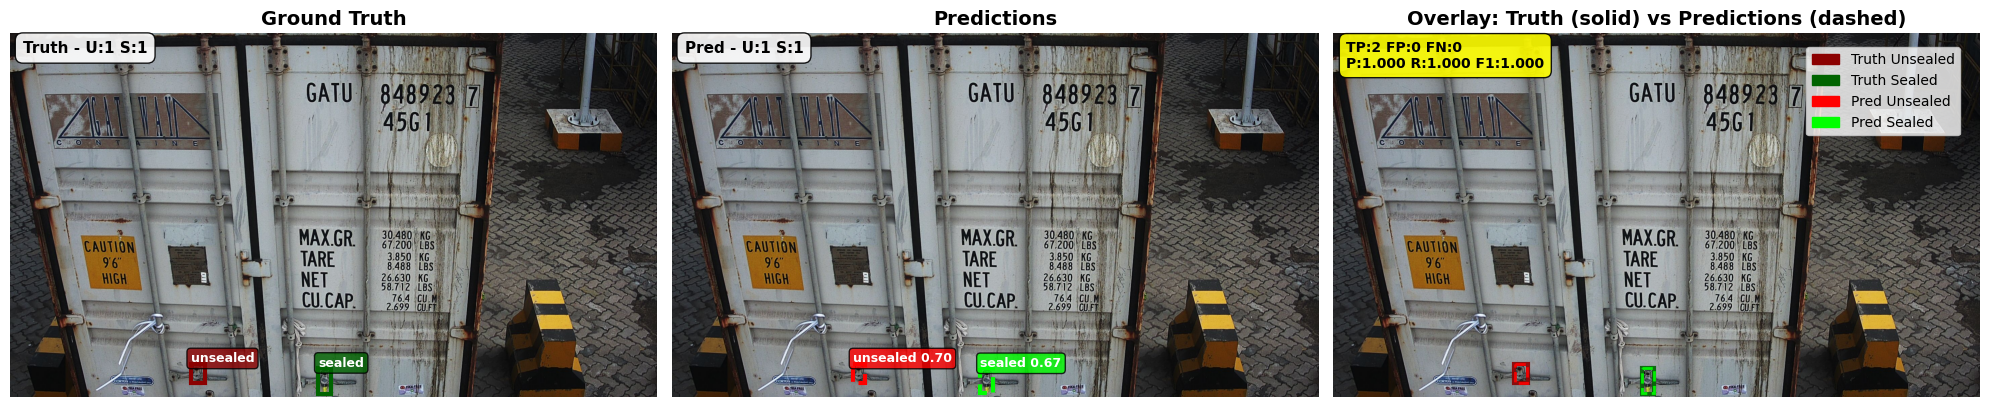

   Results for 1-140105001-OCR-AS-B01.jpg:
   TP: 2, FP: 0, FN: 0
   Precision: 1.000, Recall: 1.000, F1: 1.000

🖼️  Example 2: Batch Prediction vs Truth Comparison


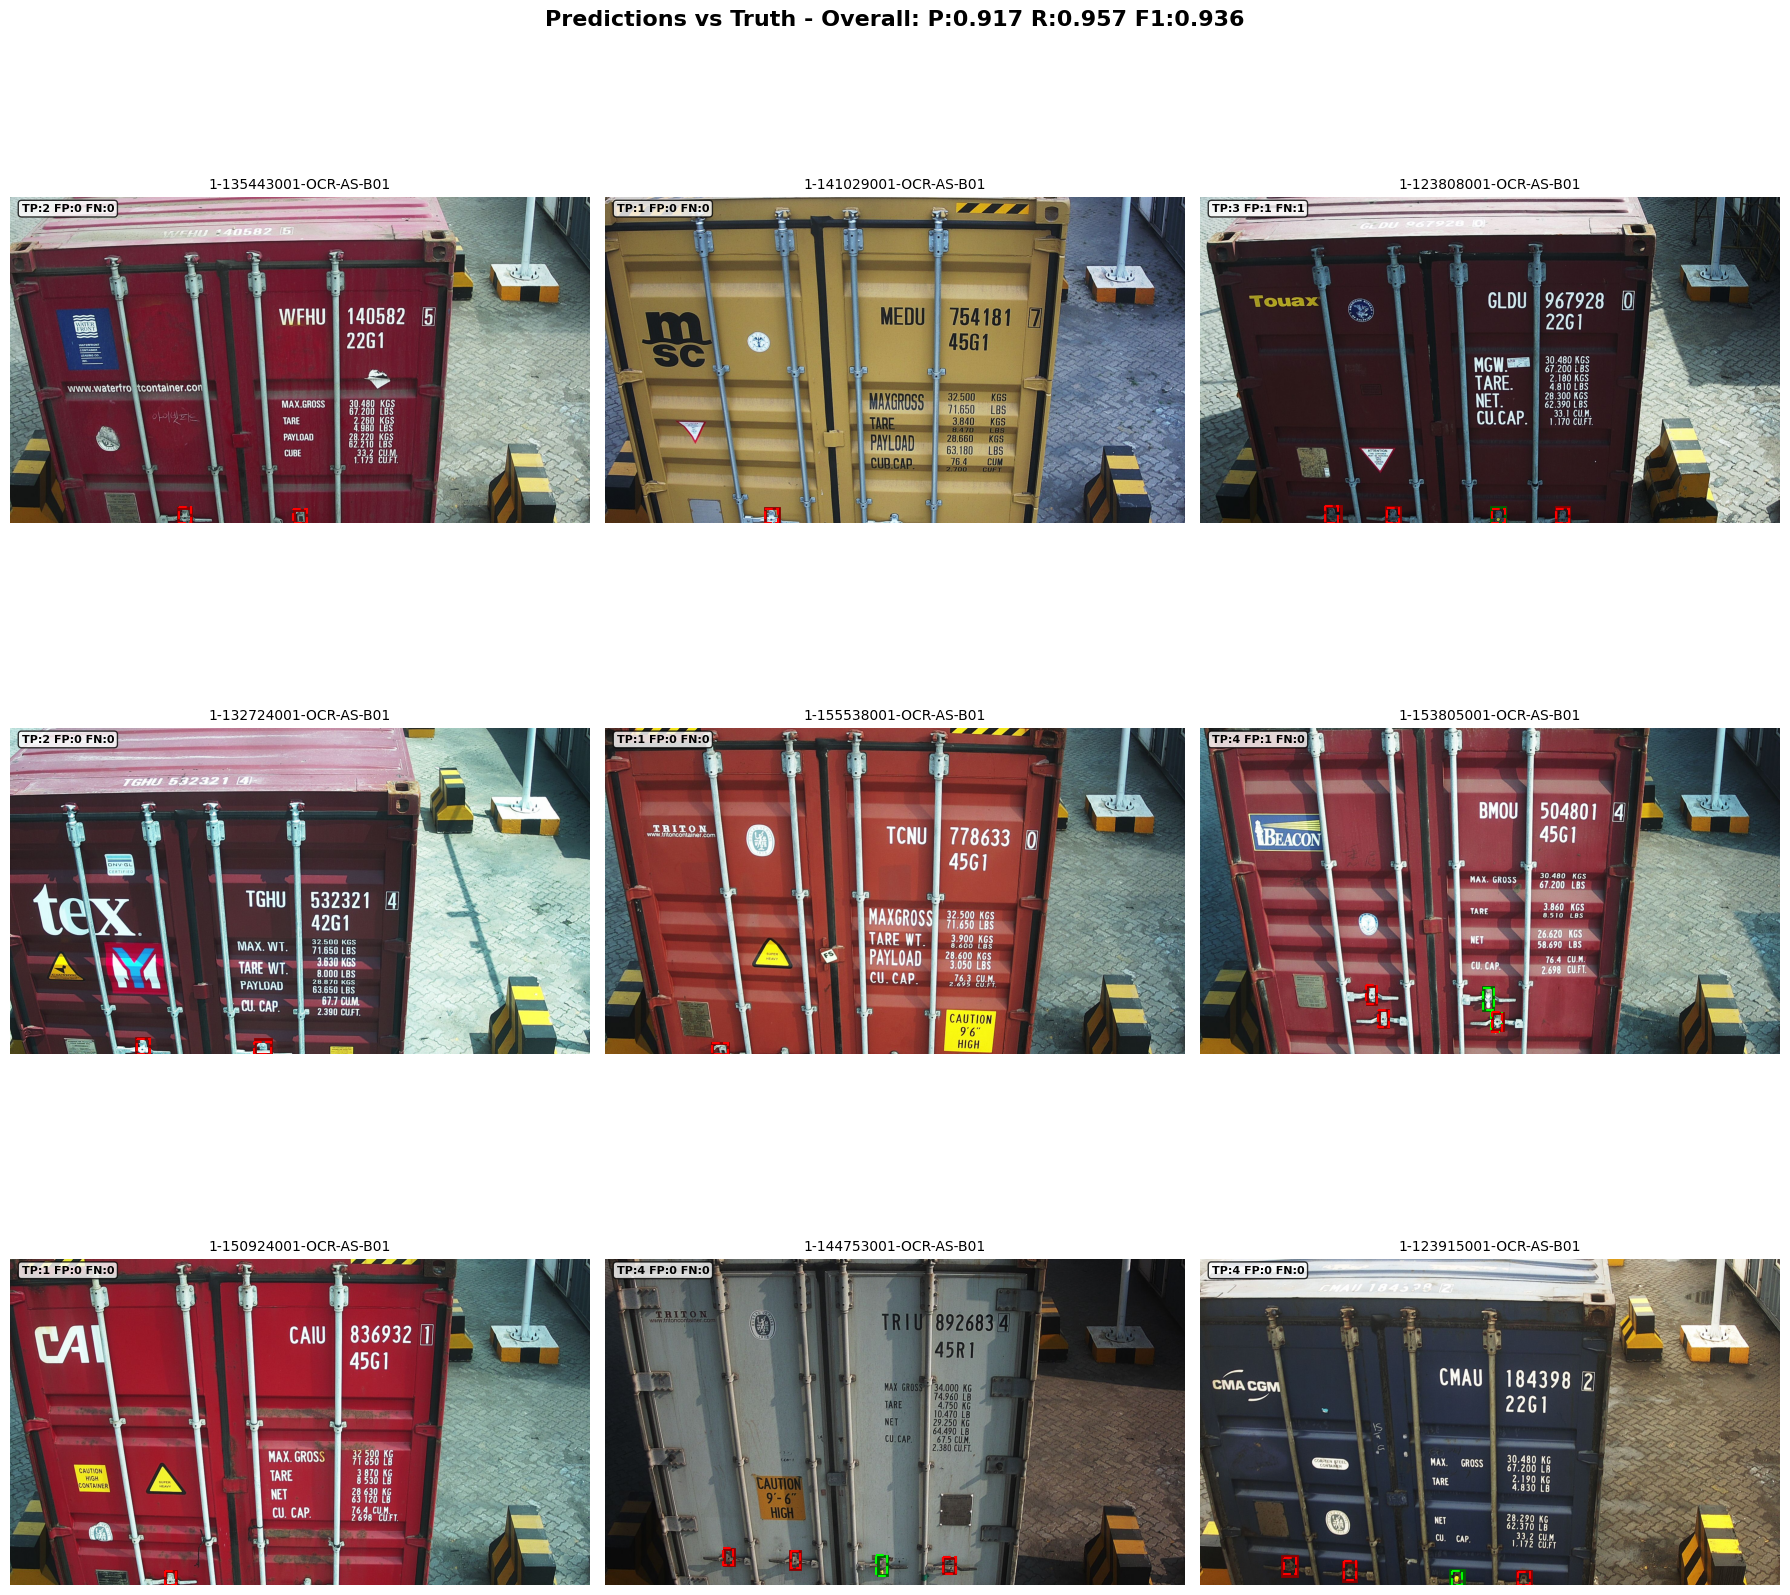

   Batch results:
   Overall TP: 22, FP: 2, FN: 1

📊 Example 3: Comprehensive Model Evaluation
📊 Evaluating model performance...
   Evaluating 50 images...
   Processed 20/50 images...
   Processed 40/50 images...


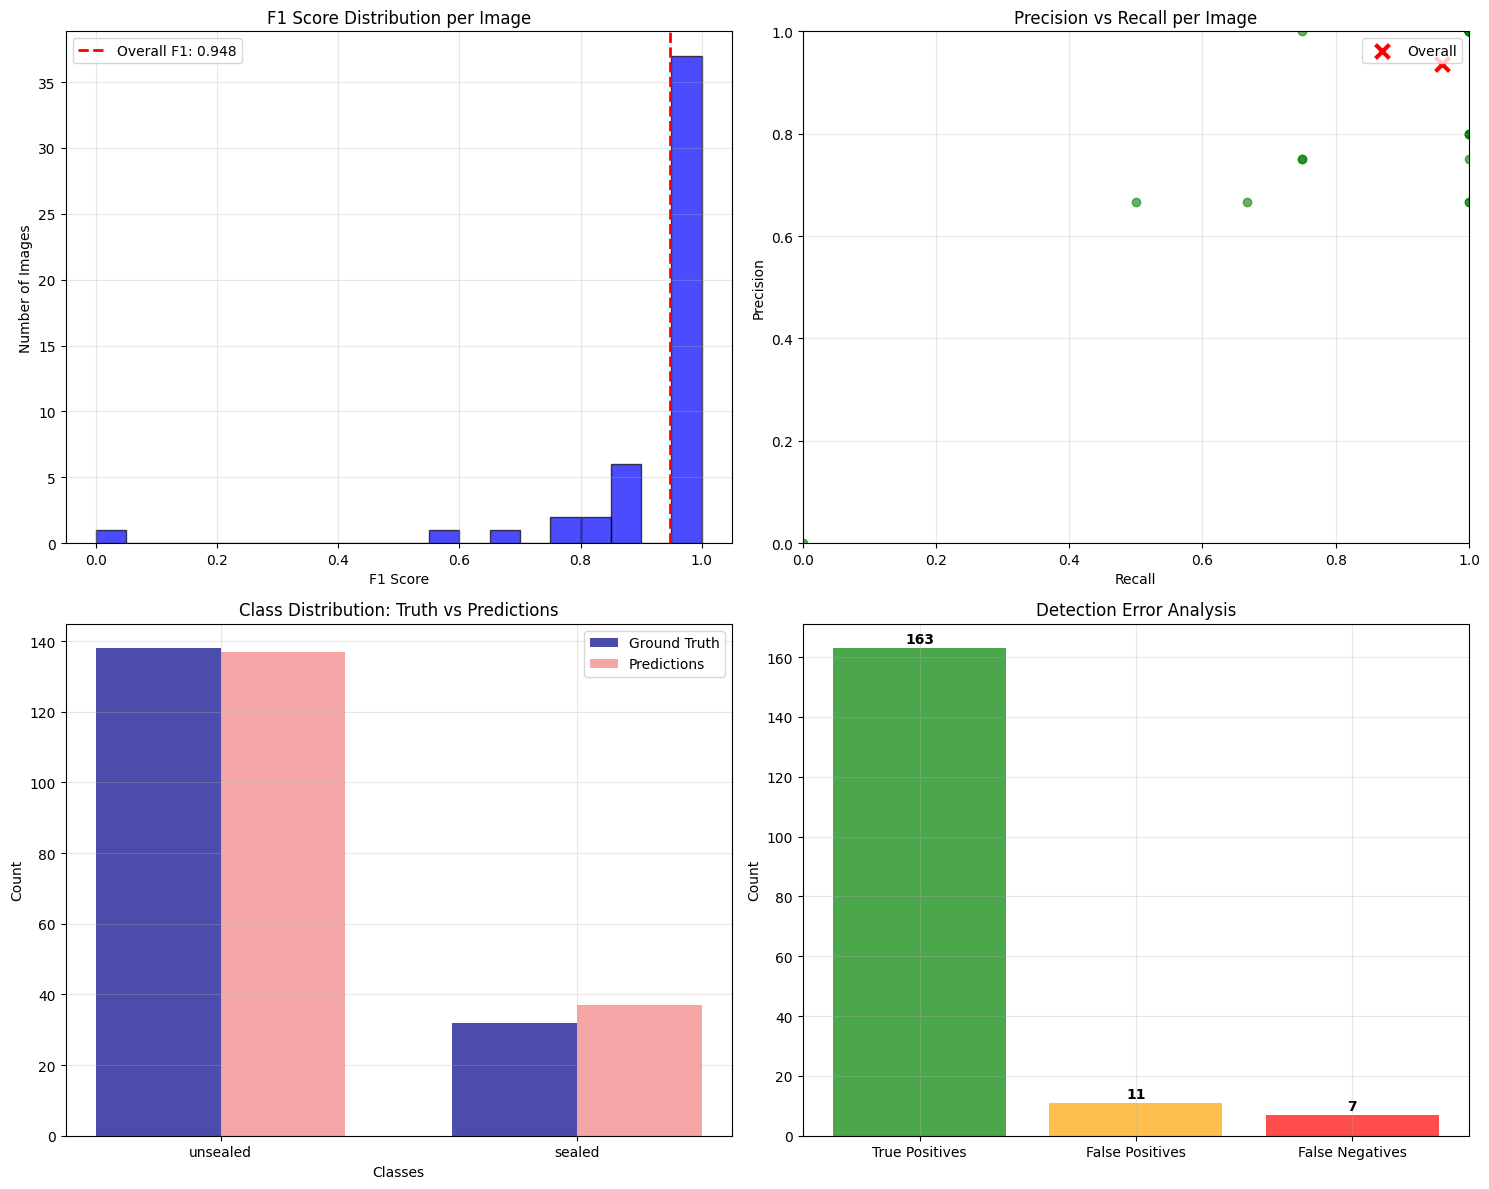


📊 Model Performance Summary:
   Images evaluated: 50
   Overall Precision: 0.937
   Overall Recall: 0.959
   Overall F1 Score: 0.948

   True Positives: 163
   False Positives: 11
   False Negatives: 7

📋 Class Statistics:
   unsealed:
     Ground Truth: 138
     Predictions: 137
     Difference: -1
   sealed:
     Ground Truth: 32
     Predictions: 37
     Difference: +5

💾 Detailed results saved to: evaluation_results.csv

📈 Example 4: Confusion Matrix Analysis
🔄 Creating confusion matrix...
📊 Evaluating model performance...
   Evaluating 50 images...
   Processed 20/50 images...
   Processed 40/50 images...


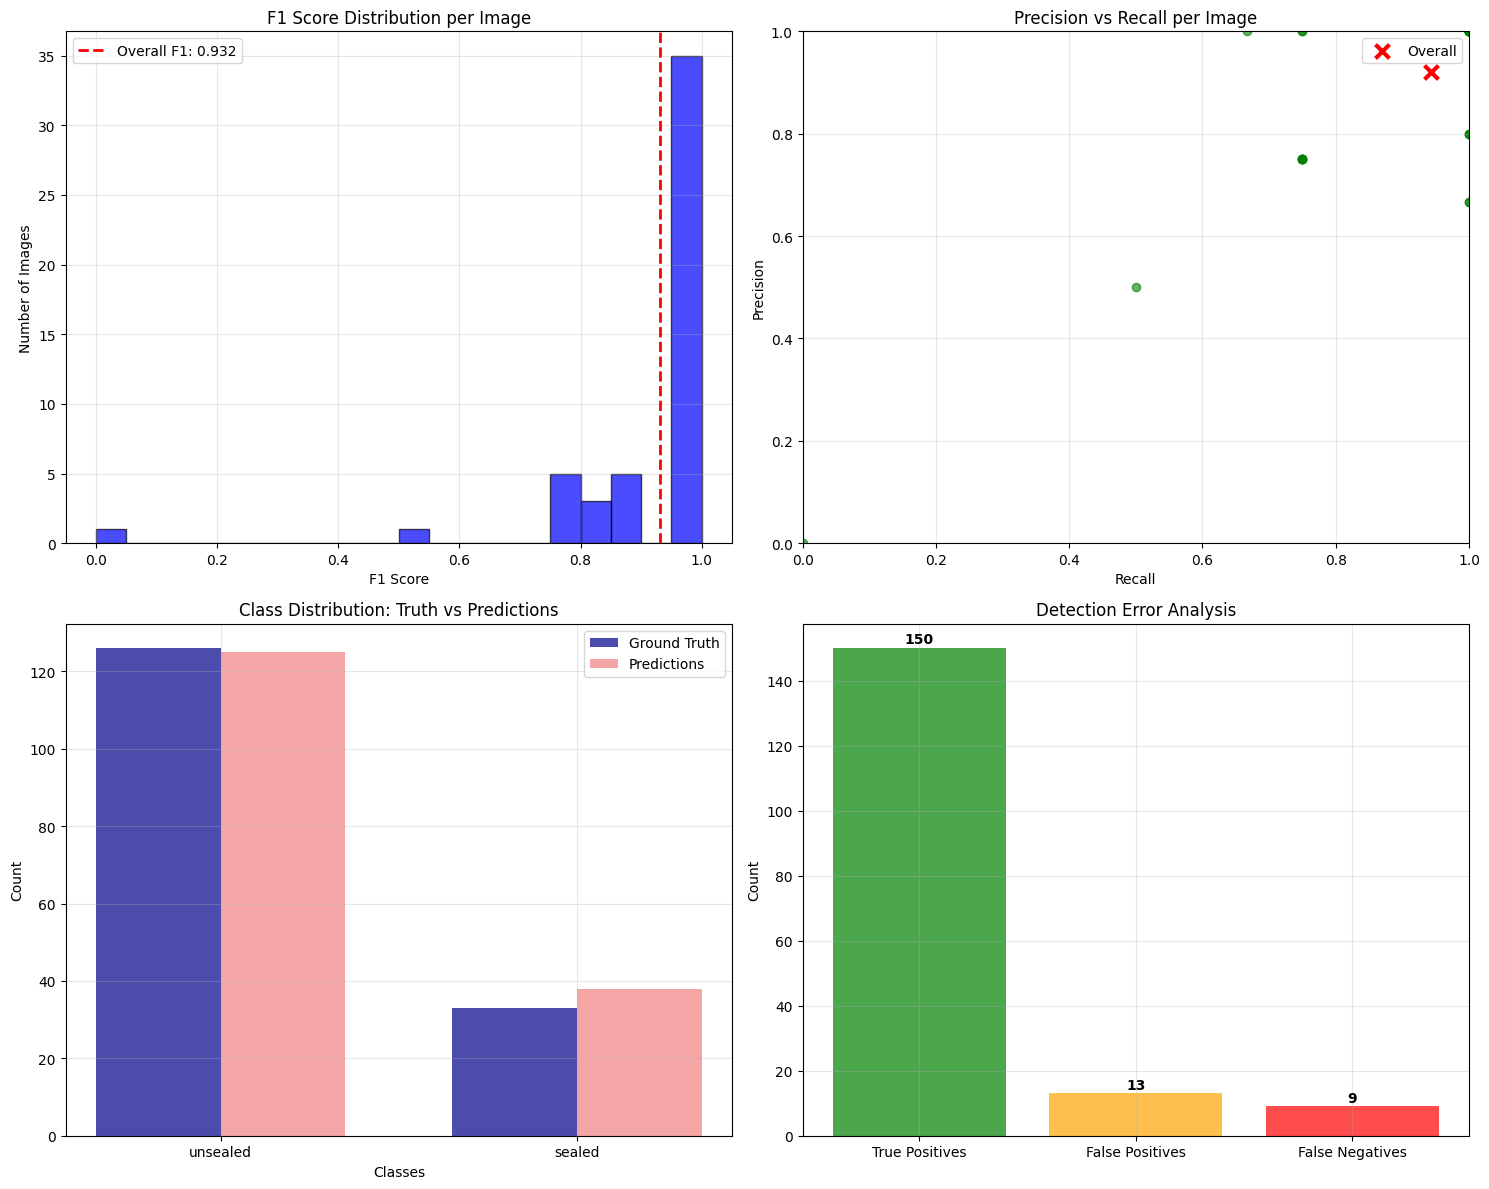


📊 Model Performance Summary:
   Images evaluated: 50
   Overall Precision: 0.920
   Overall Recall: 0.943
   Overall F1 Score: 0.932

   True Positives: 150
   False Positives: 13
   False Negatives: 9

📋 Class Statistics:
   unsealed:
     Ground Truth: 126
     Predictions: 125
     Difference: -1
   sealed:
     Ground Truth: 33
     Predictions: 38
     Difference: +5

💾 Detailed results saved to: evaluation_results.csv


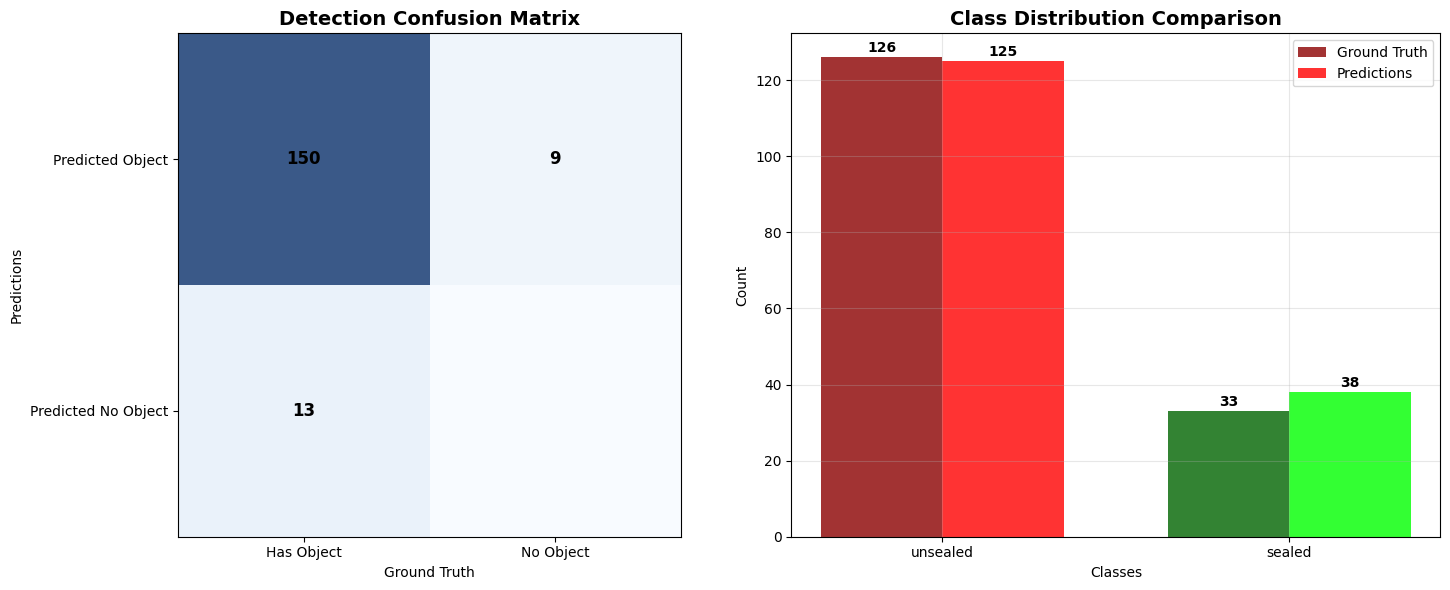


🎉 Prediction vs Truth analysis completed!

📋 Final Model Performance Summary:
   Overall Precision: 0.937
   Overall Recall: 0.959
   Overall F1 Score: 0.948
   True Positives: 163
   False Positives: 11
   False Negatives: 7


In [3]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from pathlib import Path
import random
from collections import defaultdict
import pandas as pd

try:
    from ultralytics import YOLO
except ImportError:
    print("Installing ultralytics...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])
    from ultralytics import YOLO

class SealPredictionVsTruthVisualization:
    def __init__(self, model_path, class_names=['unsealed', 'sealed']):
        """
        Initialize the visualization class for comparing predictions vs ground truth

        Args:
            model_path: Path to trained YOLOv8 model
            class_names: List of class names
        """
        self.model = YOLO(model_path)
        self.class_names = class_names
        # Colors: truth (solid), predictions (dashed)
        self.truth_colors = ['darkred', 'darkgreen']  # Ground truth colors
        self.pred_colors = ['red', 'lime']  # Prediction colors
        print(f"✅ Loaded model from {model_path}")

    def load_ground_truth(self, label_path, img_width, img_height):
        """
        Load ground truth annotations from YOLO format label file

        Args:
            label_path: Path to the label file
            img_width: Image width
            img_height: Image height

        Returns:
            List of ground truth boxes and classes
        """
        truth_boxes = []
        truth_classes = []

        if not Path(label_path).exists():
            return truth_boxes, truth_classes

        try:
            with open(label_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        parts = line.split()
                        if len(parts) == 5:
                            try:
                                class_id = int(parts[0])
                                x_center, y_center, width, height = map(float, parts[1:5])

                                # Convert from normalized YOLO format to pixel coordinates
                                x1 = (x_center - width/2) * img_width
                                y1 = (y_center - height/2) * img_height
                                x2 = (x_center + width/2) * img_width
                                y2 = (y_center + height/2) * img_height

                                truth_boxes.append([x1, y1, x2, y2])
                                truth_classes.append(class_id)
                            except ValueError:
                                continue
        except Exception as e:
            print(f"⚠️ Error reading {label_path}: {e}")

        return truth_boxes, truth_classes

    def predict_single_image(self, image_path, conf_threshold=0.25, iou_threshold=0.45):
        """
        Run prediction on a single image

        Args:
            image_path: Path to the image
            conf_threshold: Confidence threshold for detections
            iou_threshold: IoU threshold for NMS

        Returns:
            results: YOLO results object
        """
        results = self.model(image_path, conf=conf_threshold, iou=iou_threshold, verbose=False)
        return results[0]

    def calculate_iou(self, box1, box2):
        """
        Calculate IoU between two boxes

        Args:
            box1, box2: [x1, y1, x2, y2] format

        Returns:
            IoU value
        """
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        if x2 <= x1 or y2 <= y1:
            return 0.0

        intersection = (x2 - x1) * (y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0.0

    def match_predictions_to_truth(self, pred_boxes, pred_classes, pred_confs,
                                 truth_boxes, truth_classes, iou_threshold=0.5):
        """
        Match predictions to ground truth boxes

        Returns:
            matched_preds: List of (pred_idx, truth_idx, iou) for matches
            unmatched_preds: List of prediction indices without matches
            unmatched_truth: List of truth indices without matches
        """
        matched_preds = []
        unmatched_preds = list(range(len(pred_boxes)))
        unmatched_truth = list(range(len(truth_boxes)))

        # For each prediction, find best matching ground truth
        for pred_idx, (pred_box, pred_class) in enumerate(zip(pred_boxes, pred_classes)):
            best_iou = 0
            best_truth_idx = -1

            for truth_idx, (truth_box, truth_class) in enumerate(zip(truth_boxes, truth_classes)):
                if truth_idx not in unmatched_truth:
                    continue

                # Only match if classes are the same
                if pred_class == truth_class:
                    iou = self.calculate_iou(pred_box, truth_box)
                    if iou > best_iou and iou >= iou_threshold:
                        best_iou = iou
                        best_truth_idx = truth_idx

            if best_truth_idx != -1:
                matched_preds.append((pred_idx, best_truth_idx, best_iou))
                unmatched_preds.remove(pred_idx)
                unmatched_truth.remove(best_truth_idx)

        return matched_preds, unmatched_preds, unmatched_truth

    def visualize_prediction_vs_truth(self, image_path, label_path, conf_threshold=0.25,
                                    save_path=None, iou_threshold=0.5):
        """
        Visualize predictions vs ground truth for a single image

        Args:
            image_path: Path to the image
            label_path: Path to the corresponding label file
            conf_threshold: Confidence threshold for predictions
            save_path: Path to save the visualization
            iou_threshold: IoU threshold for matching
        """
        # Load image
        image = Image.open(image_path).convert('RGB')
        img_array = np.array(image)
        img_height, img_width = img_array.shape[:2]

        # Get predictions
        results = self.predict_single_image(image_path, conf_threshold)

        # Load ground truth
        truth_boxes, truth_classes = self.load_ground_truth(label_path, img_width, img_height)

        # Extract predictions
        pred_boxes, pred_classes, pred_confs = [], [], []
        if results.boxes is not None and len(results.boxes) > 0:
            pred_boxes = results.boxes.xyxy.cpu().numpy().tolist()
            pred_classes = results.boxes.cls.cpu().numpy().astype(int).tolist()
            pred_confs = results.boxes.conf.cpu().numpy().tolist()

        # Match predictions to truth
        matched_preds, unmatched_preds, unmatched_truth = self.match_predictions_to_truth(
            pred_boxes, pred_classes, pred_confs, truth_boxes, truth_classes, iou_threshold
        )

        # Create visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        # 1. Ground Truth Only
        ax1.imshow(img_array)
        ax1.set_title('Ground Truth', fontsize=14, fontweight='bold')
        ax1.axis('off')

        truth_counts = defaultdict(int)
        for box, cls in zip(truth_boxes, truth_classes):
            x1, y1, x2, y2 = box
            class_name = self.class_names[cls]
            color = self.truth_colors[cls]
            truth_counts[class_name] += 1

            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=3, edgecolor=color, facecolor='none',
                                   linestyle='-')
            ax1.add_patch(rect)

            ax1.text(x1, y1-5, class_name,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                    fontsize=9, color='white', fontweight='bold')

        truth_text = f"Truth - U:{truth_counts['unsealed']} S:{truth_counts['sealed']}"
        ax1.text(0.02, 0.98, truth_text, transform=ax1.transAxes,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9),
                fontsize=11, verticalalignment='top', fontweight='bold')

        # 2. Predictions Only
        ax2.imshow(img_array)
        ax2.set_title('Predictions', fontsize=14, fontweight='bold')
        ax2.axis('off')

        pred_counts = defaultdict(int)
        for box, cls, conf in zip(pred_boxes, pred_classes, pred_confs):
            x1, y1, x2, y2 = box
            class_name = self.class_names[cls]
            color = self.pred_colors[cls]
            pred_counts[class_name] += 1

            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=3, edgecolor=color, facecolor='none',
                                   linestyle='--')
            ax2.add_patch(rect)

            ax2.text(x1, y1-5, f"{class_name} {conf:.2f}",
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                    fontsize=9, color='white', fontweight='bold')

        pred_text = f"Pred - U:{pred_counts['unsealed']} S:{pred_counts['sealed']}"
        ax2.text(0.02, 0.98, pred_text, transform=ax2.transAxes,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9),
                fontsize=11, verticalalignment='top', fontweight='bold')

        # 3. Overlay (Truth + Predictions with matching)
        ax3.imshow(img_array)
        ax3.set_title('Overlay: Truth (solid) vs Predictions (dashed)', fontsize=14, fontweight='bold')
        ax3.axis('off')

        # Draw ground truth (solid lines)
        for i, (box, cls) in enumerate(zip(truth_boxes, truth_classes)):
            x1, y1, x2, y2 = box
            class_name = self.class_names[cls]
            color = self.truth_colors[cls]

            # Check if this truth box is matched
            is_matched = any(truth_idx == i for _, truth_idx, _ in matched_preds)
            alpha = 0.9 if is_matched else 0.6

            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=3, edgecolor=color, facecolor='none',
                                   linestyle='-', alpha=alpha)
            ax3.add_patch(rect)

        # Draw predictions (dashed lines)
        for i, (box, cls, conf) in enumerate(zip(pred_boxes, pred_classes, pred_confs)):
            x1, y1, x2, y2 = box
            class_name = self.class_names[cls]
            color = self.pred_colors[cls]

            # Check if this prediction is matched
            match_info = next((m for m in matched_preds if m[0] == i), None)
            if match_info:
                # Matched prediction - show IoU
                iou = match_info[2]
                linestyle = '--'
                alpha = 0.9
                label = f"{class_name} {conf:.2f} (IoU:{iou:.2f})"
            else:
                # Unmatched prediction
                linestyle = ':'
                alpha = 0.7
                label = f"{class_name} {conf:.2f} (FP)"

            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2, edgecolor=color, facecolor='none',
                                   linestyle=linestyle, alpha=alpha)
            ax3.add_patch(rect)

        # Add statistics
        tp = len(matched_preds)  # True Positives
        fp = len(unmatched_preds)  # False Positives
        fn = len(unmatched_truth)  # False Negatives

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        stats_text = f"TP:{tp} FP:{fp} FN:{fn}\nP:{precision:.3f} R:{recall:.3f} F1:{f1:.3f}"
        ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.9),
                fontsize=10, verticalalignment='top', fontweight='bold')

        # Add legend
        legend_elements = [
            patches.Patch(color=self.truth_colors[0], label='Truth Unsealed'),
            patches.Patch(color=self.truth_colors[1], label='Truth Sealed'),
            patches.Patch(color=self.pred_colors[0], label='Pred Unsealed'),
            patches.Patch(color=self.pred_colors[1], label='Pred Sealed')
        ]
        ax3.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Saved comparison to {save_path}")

        plt.show()

        return {
            'tp': tp, 'fp': fp, 'fn': fn,
            'precision': precision, 'recall': recall, 'f1': f1,
            'truth_counts': dict(truth_counts),
            'pred_counts': dict(pred_counts)
        }

    def batch_compare_predictions_vs_truth(self, image_dir, label_dir, conf_threshold=0.25,
                                         max_images=9, save_path=None, iou_threshold=0.5):
        """
        Compare predictions vs truth for multiple images in a grid

        Args:
            image_dir: Directory containing images
            label_dir: Directory containing corresponding label files
            conf_threshold: Confidence threshold
            max_images: Maximum number of images to show
            save_path: Path to save the grid
            iou_threshold: IoU threshold for matching
        """
        # Get matching image-label pairs
        image_dir = Path(image_dir)
        label_dir = Path(label_dir)

        pairs = []
        for img_path in image_dir.glob('*.*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                lbl_path = label_dir / f"{img_path.stem}.txt"
                if lbl_path.exists():
                    pairs.append((img_path, lbl_path))

        if not pairs:
            print(f"❌ No matching image-label pairs found")
            return

        # Limit and sample
        if len(pairs) > max_images:
            pairs = random.sample(pairs, max_images)

        # Calculate grid
        n_images = len(pairs)
        cols = min(3, n_images)
        rows = (n_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
        if rows == 1 and cols == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes
        else:
            axes = axes.flatten()

        overall_stats = {'tp': 0, 'fp': 0, 'fn': 0}

        for idx, (image_path, label_path) in enumerate(pairs):
            if idx >= len(axes):
                break

            ax = axes[idx]

            # Load image
            image = Image.open(image_path).convert('RGB')
            img_array = np.array(image)
            img_height, img_width = img_array.shape[:2]

            # Get predictions and truth
            results = self.predict_single_image(image_path, conf_threshold)
            truth_boxes, truth_classes = self.load_ground_truth(label_path, img_width, img_height)

            # Extract predictions
            pred_boxes, pred_classes, pred_confs = [], [], []
            if results.boxes is not None and len(results.boxes) > 0:
                pred_boxes = results.boxes.xyxy.cpu().numpy().tolist()
                pred_classes = results.boxes.cls.cpu().numpy().astype(int).tolist()
                pred_confs = results.boxes.conf.cpu().numpy().tolist()

            # Match predictions
            matched_preds, unmatched_preds, unmatched_truth = self.match_predictions_to_truth(
                pred_boxes, pred_classes, pred_confs, truth_boxes, truth_classes, iou_threshold
            )

            # Update overall stats
            overall_stats['tp'] += len(matched_preds)
            overall_stats['fp'] += len(unmatched_preds)
            overall_stats['fn'] += len(unmatched_truth)

            # Visualize
            ax.imshow(img_array)
            ax.set_title(f'{Path(image_path).stem}', fontsize=10)
            ax.axis('off')

            # Draw truth (solid)
            for box, cls in zip(truth_boxes, truth_classes):
                x1, y1, x2, y2 = box
                color = self.truth_colors[cls]
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                       linewidth=2, edgecolor=color, facecolor='none', linestyle='-')
                ax.add_patch(rect)

            # Draw predictions (dashed)
            for box, cls, conf in zip(pred_boxes, pred_classes, pred_confs):
                x1, y1, x2, y2 = box
                color = self.pred_colors[cls]
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                       linewidth=1.5, edgecolor=color, facecolor='none', linestyle='--')
                ax.add_patch(rect)

            # Add stats
            tp = len(matched_preds)
            fp = len(unmatched_preds)
            fn = len(unmatched_truth)

            stats_text = f"TP:{tp} FP:{fp} FN:{fn}"
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                   fontsize=8, verticalalignment='top', fontweight='bold')

        # Hide unused subplots
        for idx in range(len(pairs), len(axes)):
            axes[idx].axis('off')

        # Calculate overall metrics
        tp_total = overall_stats['tp']
        fp_total = overall_stats['fp']
        fn_total = overall_stats['fn']

        precision = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
        recall = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        title_text = f"Predictions vs Truth - Overall: P:{precision:.3f} R:{recall:.3f} F1:{f1:.3f}"
        fig.suptitle(title_text, fontsize=16, fontweight='bold', y=0.98)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Saved batch comparison to {save_path}")

        plt.show()

        return overall_stats

    def evaluate_model_performance(self, image_dir, label_dir, conf_threshold=0.25,
                                 iou_threshold=0.5, max_samples=100):
        """
        Comprehensive evaluation of model performance

        Args:
            image_dir: Directory containing images
            label_dir: Directory containing labels
            conf_threshold: Confidence threshold
            iou_threshold: IoU threshold for matching
            max_samples: Maximum samples to evaluate
        """
        print(f"📊 Evaluating model performance...")

        # Get image-label pairs
        image_dir = Path(image_dir)
        label_dir = Path(label_dir)

        pairs = []
        for img_path in image_dir.glob('*.*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                lbl_path = label_dir / f"{img_path.stem}.txt"
                if lbl_path.exists():
                    pairs.append((img_path, lbl_path))

        if not pairs:
            print("❌ No matching pairs found")
            return

        # Limit samples
        if len(pairs) > max_samples:
            pairs = random.sample(pairs, max_samples)

        print(f"   Evaluating {len(pairs)} images...")

        # Collect results
        all_results = []
        overall_stats = defaultdict(int)
        class_stats = defaultdict(lambda: defaultdict(int))

        for i, (image_path, label_path) in enumerate(pairs):
            if (i + 1) % 20 == 0:
                print(f"   Processed {i + 1}/{len(pairs)} images...")

            # Load image
            image = Image.open(image_path).convert('RGB')
            img_array = np.array(image)
            img_height, img_width = img_array.shape[:2]

            # Get predictions and truth
            results = self.predict_single_image(image_path, conf_threshold)
            truth_boxes, truth_classes = self.load_ground_truth(label_path, img_width, img_height)

            # Extract predictions
            pred_boxes, pred_classes, pred_confs = [], [], []
            if results.boxes is not None and len(results.boxes) > 0:
                pred_boxes = results.boxes.xyxy.cpu().numpy().tolist()
                pred_classes = results.boxes.cls.cpu().numpy().astype(int).tolist()
                pred_confs = results.boxes.conf.cpu().numpy().tolist()

            # Match predictions
            matched_preds, unmatched_preds, unmatched_truth = self.match_predictions_to_truth(
                pred_boxes, pred_classes, pred_confs, truth_boxes, truth_classes, iou_threshold
            )

            # Calculate metrics for this image
            tp = len(matched_preds)
            fp = len(unmatched_preds)
            fn = len(unmatched_truth)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            # Count by class
            truth_counts = defaultdict(int)
            pred_counts = defaultdict(int)

            for cls in truth_classes:
                truth_counts[self.class_names[cls]] += 1
            for cls in pred_classes:
                pred_counts[self.class_names[cls]] += 1

            # Store results
            result = {
                'image_name': Path(image_path).name,
                'tp': tp, 'fp': fp, 'fn': fn,
                'precision': precision, 'recall': recall, 'f1': f1,
                'truth_unsealed': truth_counts['unsealed'],
                'truth_sealed': truth_counts['sealed'],
                'pred_unsealed': pred_counts['unsealed'],
                'pred_sealed': pred_counts['sealed']
            }
            all_results.append(result)

            # Update overall stats
            overall_stats['tp'] += tp
            overall_stats['fp'] += fp
            overall_stats['fn'] += fn

            # Update class stats
            for cls_name in self.class_names:
                class_stats[cls_name]['truth'] += truth_counts[cls_name]
                class_stats[cls_name]['pred'] += pred_counts[cls_name]

        # Calculate overall metrics
        tp_total = overall_stats['tp']
        fp_total = overall_stats['fp']
        fn_total = overall_stats['fn']

        overall_precision = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
        overall_recall = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
        overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

        # Create evaluation plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Per-image metrics distribution
        ax1 = axes[0, 0]
        df = pd.DataFrame(all_results)
        ax1.hist(df['f1'], bins=20, alpha=0.7, color='blue', edgecolor='black')
        ax1.axvline(overall_f1, color='red', linestyle='--', linewidth=2, label=f'Overall F1: {overall_f1:.3f}')
        ax1.set_title('F1 Score Distribution per Image')
        ax1.set_xlabel('F1 Score')
        ax1.set_ylabel('Number of Images')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Precision vs Recall scatter
        ax2 = axes[0, 1]
        ax2.scatter(df['recall'], df['precision'], alpha=0.6, c='green')
        ax2.scatter(overall_recall, overall_precision, color='red', s=100, marker='x', linewidth=3, label='Overall')
        ax2.set_title('Precision vs Recall per Image')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # 3. Class distribution comparison
        ax3 = axes[1, 0]
        class_names = list(class_stats.keys())
        truth_values = [class_stats[name]['truth'] for name in class_names]
        pred_values = [class_stats[name]['pred'] for name in class_names]

        x = np.arange(len(class_names))
        width = 0.35

        ax3.bar(x - width/2, truth_values, width, label='Ground Truth', color='darkblue', alpha=0.7)
        ax3.bar(x + width/2, pred_values, width, label='Predictions', color='lightcoral', alpha=0.7)
        ax3.set_title('Class Distribution: Truth vs Predictions')
        ax3.set_xlabel('Classes')
        ax3.set_ylabel('Count')
        ax3.set_xticks(x)
        ax3.set_xticklabels(class_names)
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Detection errors
        ax4 = axes[1, 1]
        error_types = ['True Positives', 'False Positives', 'False Negatives']
        error_counts = [tp_total, fp_total, fn_total]
        colors = ['green', 'orange', 'red']

        ax4.bar(error_types, error_counts, color=colors, alpha=0.7)
        ax4.set_title('Detection Error Analysis')
        ax4.set_ylabel('Count')
        ax4.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(error_counts):
            ax4.text(i, v + max(error_counts)*0.01, str(v), ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\n📊 Model Performance Summary:")
        print(f"   Images evaluated: {len(pairs)}")
        print(f"   Overall Precision: {overall_precision:.3f}")
        print(f"   Overall Recall: {overall_recall:.3f}")
        print(f"   Overall F1 Score: {overall_f1:.3f}")
        print(f"\n   True Positives: {tp_total}")
        print(f"   False Positives: {fp_total}")
        print(f"   False Negatives: {fn_total}")

        print(f"\n📋 Class Statistics:")
        for class_name in self.class_names:
            truth_count = class_stats[class_name]['truth']
            pred_count = class_stats[class_name]['pred']
            print(f"   {class_name}:")
            print(f"     Ground Truth: {truth_count}")
            print(f"     Predictions: {pred_count}")
            print(f"     Difference: {pred_count - truth_count:+d}")

        # Save detailed results
        df.to_csv('evaluation_results.csv', index=False)
        print(f"\n💾 Detailed results saved to: evaluation_results.csv")

        return {
            'overall_metrics': {
                'precision': overall_precision,
                'recall': overall_recall,
                'f1': overall_f1,
                'tp': tp_total,
                'fp': fp_total,
                'fn': fn_total
            },
            'class_stats': dict(class_stats),
            'per_image_results': all_results
        }

    def create_confusion_matrix_visualization(self, image_dir, label_dir, conf_threshold=0.25,
                                            iou_threshold=0.5, max_samples=100):
        """
        Create confusion matrix visualization for detection results
        """
        print("🔄 Creating confusion matrix...")

        # Get evaluation results
        eval_results = self.evaluate_model_performance(
            image_dir, label_dir, conf_threshold, iou_threshold, max_samples
        )

        if not eval_results:
            return

        # Extract class statistics
        class_stats = eval_results['class_stats']

        # Create confusion matrix-style visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # 1. Detection Confusion Matrix
        detection_matrix = np.array([
            [eval_results['overall_metrics']['tp'], eval_results['overall_metrics']['fn']],
            [eval_results['overall_metrics']['fp'], 0]  # True Negatives not applicable in detection
        ])

        labels = ['Detected', 'Missed']
        im1 = ax1.imshow(detection_matrix, cmap='Blues', alpha=0.8)
        ax1.set_title('Detection Confusion Matrix', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Ground Truth')
        ax1.set_ylabel('Predictions')
        ax1.set_xticks([0, 1])
        ax1.set_yticks([0, 1])
        ax1.set_xticklabels(['Has Object', 'No Object'])
        ax1.set_yticklabels(['Predicted Object', 'Predicted No Object'])

        # Add text annotations
        for i in range(2):
            for j in range(2):
                if detection_matrix[i, j] > 0:
                    text = ax1.text(j, i, detection_matrix[i, j],
                                  ha='center', va='center', fontsize=12, fontweight='bold')

        # 2. Class Distribution Comparison
        class_names = list(class_stats.keys())
        truth_counts = [class_stats[name]['truth'] for name in class_names]
        pred_counts = [class_stats[name]['pred'] for name in class_names]

        x = np.arange(len(class_names))
        width = 0.35

        bars1 = ax2.bar(x - width/2, truth_counts, width, label='Ground Truth',
                       color=['darkred', 'darkgreen'], alpha=0.8)
        bars2 = ax2.bar(x + width/2, pred_counts, width, label='Predictions',
                       color=['red', 'lime'], alpha=0.8)

        ax2.set_title('Class Distribution Comparison', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Classes')
        ax2.set_ylabel('Count')
        ax2.set_xticks(x)
        ax2.set_xticklabels(class_names)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{int(height)}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

# ===================== Usage Examples =====================

def main():
    """Main function with usage examples"""

    # Configuration
    MODEL_PATH = "seal_detection/yolov8s_finetuned2/weights/best.pt"  # Your trained model
    IMAGES_DIR = "images2/val"  # Directory containing images
    LABELS_DIR = "labels/val"  # Directory containing corresponding YOLO label files
    CONF_THRESHOLD = 0.25  # Confidence threshold
    IOU_THRESHOLD = 0.5   # IoU threshold for matching predictions to truth

    # Check if model exists
    if not Path(MODEL_PATH).exists():
        print(f"❌ Model not found at {MODEL_PATH}")
        print("💡 Please update MODEL_PATH to point to your trained model")
        print("   Common locations:")
        print("   - runs/detect/yolov8s_finetuned/weights/best.pt")
        print("   - runs/detect/train/weights/best.pt")
        return

    # Check directories
    missing_dirs = []
    for name, path in [("Images", IMAGES_DIR), ("Labels", LABELS_DIR)]:
        if not Path(path).exists():
            missing_dirs.append(f"{name}: {path}")

    if missing_dirs:
        print("❌ Missing directories:")
        for dir_info in missing_dirs:
            print(f"   {dir_info}")
        print("\n💡 Please update the paths to match your data structure")
        return

    print("✅ All paths verified")

    # Initialize visualization
    print("🎨 Initializing prediction vs truth visualization...")
    viz = SealPredictionVsTruthVisualization(MODEL_PATH)

    # Get sample image-label pairs
    image_dir = Path(IMAGES_DIR)
    label_dir = Path(LABELS_DIR)

    pairs = []
    for img_path in image_dir.glob('*.*'):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            lbl_path = label_dir / f"{img_path.stem}.txt"
            if lbl_path.exists():
                pairs.append((img_path, lbl_path))

    if not pairs:
        print("❌ No matching image-label pairs found")
        print("💡 Make sure your label files have the same names as image files (but with .txt extension)")
        return

    print(f"✅ Found {len(pairs)} matching image-label pairs")

    # Example 1: Single image comparison
    print("\n🖼️  Example 1: Single Image Prediction vs Truth")
    sample_pair = random.choice(pairs)
    image_path, label_path = sample_pair

    result = viz.visualize_prediction_vs_truth(
        image_path, label_path,
        conf_threshold=CONF_THRESHOLD,
        iou_threshold=IOU_THRESHOLD
    )

    print(f"   Results for {Path(image_path).name}:")
    print(f"   TP: {result['tp']}, FP: {result['fp']}, FN: {result['fn']}")
    print(f"   Precision: {result['precision']:.3f}, Recall: {result['recall']:.3f}, F1: {result['f1']:.3f}")

    # Example 2: Batch comparison
    print("\n🖼️  Example 2: Batch Prediction vs Truth Comparison")
    sample_pairs = random.sample(pairs, min(9, len(pairs)))

    overall_stats = viz.batch_compare_predictions_vs_truth(
        IMAGES_DIR, LABELS_DIR,
        conf_threshold=CONF_THRESHOLD,
        max_images=9,
        iou_threshold=IOU_THRESHOLD
    )

    print(f"   Batch results:")
    print(f"   Overall TP: {overall_stats['tp']}, FP: {overall_stats['fp']}, FN: {overall_stats['fn']}")

    # Example 3: Full model evaluation
    print("\n📊 Example 3: Comprehensive Model Evaluation")
    evaluation_results = viz.evaluate_model_performance(
        IMAGES_DIR, LABELS_DIR,
        conf_threshold=CONF_THRESHOLD,
        iou_threshold=IOU_THRESHOLD,
        max_samples=50
    )

    # Example 4: Confusion matrix visualization
    print("\n📈 Example 4: Confusion Matrix Analysis")
    viz.create_confusion_matrix_visualization(
        IMAGES_DIR, LABELS_DIR,
        conf_threshold=CONF_THRESHOLD,
        iou_threshold=IOU_THRESHOLD,
        max_samples=50
    )

    print("\n" + "="*60)
    print("🎉 Prediction vs Truth analysis completed!")
    print("="*60)

    # Final summary
    if evaluation_results:
        metrics = evaluation_results['overall_metrics']
        print(f"\n📋 Final Model Performance Summary:")
        print(f"   Overall Precision: {metrics['precision']:.3f}")
        print(f"   Overall Recall: {metrics['recall']:.3f}")
        print(f"   Overall F1 Score: {metrics['f1']:.3f}")
        print(f"   True Positives: {metrics['tp']}")
        print(f"   False Positives: {metrics['fp']}")
        print(f"   False Negatives: {metrics['fn']}")

# ===================== Individual Function Examples =====================

def compare_specific_images():
    """Example of comparing specific images to their ground truth"""
    MODEL_PATH = "runs/detect/yolov8s_finetuned/weights/best.pt"

    # Specific image-label pairs you want to analyze
    specific_pairs = [
        ("path/to/image1.jpg", "path/to/label1.txt"),
        ("path/to/image2.jpg", "path/to/label2.txt"),
        ("path/to/image3.jpg", "path/to/label3.txt")
    ]

    viz = SealPredictionVsTruthVisualization(MODEL_PATH)

    for image_path, label_path in specific_pairs:
        if Path(image_path).exists() and Path(label_path).exists():
            print(f"\nAnalyzing {Path(image_path).name}...")
            result = viz.visualize_prediction_vs_truth(
                image_path, label_path,
                conf_threshold=0.3,
                save_path=f"comparison_{Path(image_path).stem}.png"
            )
            print(f"F1 Score: {result['f1']:.3f}")

def evaluate_different_thresholds():
    """Example of evaluating model at different confidence thresholds"""
    MODEL_PATH = "seal_detection/yolov8s_finetuned3/weights/best.pt"
    IMAGES_DIR = "path/to/images2/val"
    LABELS_DIR = "path/to/labels/val"

    viz = SealPredictionVsTruthVisualization(MODEL_PATH)

    thresholds = [0.1, 0.25, 0.5, 0.7, 0.9]
    results = []

    for threshold in thresholds:
        print(f"\nEvaluating at confidence threshold: {threshold}")
        eval_result = viz.evaluate_model_performance(
            IMAGES_DIR, LABELS_DIR,
            conf_threshold=threshold,
            max_samples=30
        )

        if eval_result:
            metrics = eval_result['overall_metrics']
            results.append({
                'threshold': threshold,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1']
            })

    # Plot threshold analysis
    if results:
        import matplotlib.pyplot as plt

        df = pd.DataFrame(results)

        plt.figure(figsize=(10, 6))
        plt.plot(df['threshold'], df['precision'], 'o-', label='Precision', linewidth=2)
        plt.plot(df['threshold'], df['recall'], 's-', label='Recall', linewidth=2)
        plt.plot(df['threshold'], df['f1'], '^-', label='F1 Score', linewidth=2)

        plt.xlabel('Confidence Threshold')
        plt.ylabel('Score')
        plt.title('Model Performance vs Confidence Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

if __name__ == "__main__":
    main()

In [4]:
!zip -r seal_detection.zip seal_detection

  adding: seal_detection/ (stored 0%)
  adding: seal_detection/yolov8s_finetuned2/ (stored 0%)
  adding: seal_detection/yolov8s_finetuned2/train_batch1121.jpg (deflated 10%)
  adding: seal_detection/yolov8s_finetuned2/train_batch2.jpg (deflated 5%)
  adding: seal_detection/yolov8s_finetuned2/BoxR_curve.png (deflated 13%)
  adding: seal_detection/yolov8s_finetuned2/confusion_matrix_normalized.png (deflated 30%)
  adding: seal_detection/yolov8s_finetuned2/train_batch1122.jpg (deflated 9%)
  adding: seal_detection/yolov8s_finetuned2/val_batch2_pred.jpg (deflated 5%)
  adding: seal_detection/yolov8s_finetuned2/args.yaml (deflated 53%)
  adding: seal_detection/yolov8s_finetuned2/labels.jpg (deflated 37%)
  adding: seal_detection/yolov8s_finetuned2/val_batch0_pred.jpg (deflated 5%)
  adding: seal_detection/yolov8s_finetuned2/BoxF1_curve.png (deflated 12%)
  adding: seal_detection/yolov8s_finetuned2/train_batch0.jpg (deflated 7%)
  adding: seal_detection/yolov8s_finetuned2/labels_correlogram.